## Import files

In [126]:
import os
import logging
import pandas as pd
import numpy as np

def readOneFile(url):
    return pd.read_csv(url, index_col = 0)

data = readOneFile("../Data/flights_2010_0.csv")
data = pd.DataFrame(data=data[0:1000])

## Tranform arrival and departure times

In [158]:
import math

def getTotalMinutes(time):
    time_str = str(int(time))
    if len(time_str) == 4:
        hours = time_str[0:2]
    else:
        hours = time_str[0:1]
    hours = int(hours)
        
    minutes = int(time_str[-2:])
    totalMinutes = minutes + hours * 60
    return totalMinutes

def getStringTime(totalMinutes):
    hours = math.floor(totalMinutes / 60)
    minutes = totalMinutes - (hours * 60)
    return str(hours) + ":" + str(minutes)

def calcDuration(departure_schedule, arrival_schedule):
    departure = getTotalMinutes(departure_schedule)
    arrival = getTotalMinutes(arrival_schedule)
    if arrival <= departure:
        duration = arrival - departure;
    else:
        duration = arrival - departure;
    return getStringTime(duration);

durations = []
for i, row in data.iterrows():
    duration = calcDuration(row["departure_schedule"], row["arrival_schedule"])
    durations.append(duration)

data["duration"] = durations

In [159]:
data.sort_values(by=["distance"], ascending=False)

,date,airline,airline_code,departure_airport,departure_state,departure_lat,departure_lon,departure_schedule,arrival_airport,arrival_state,arrival_lat,arrival_lon,arrival_schedule,departure_actual,departure_delay,arrival_actual,arrival_delay,distance,duration
937,2011-01-01,AA,19805,ORD,IL,41.98,-87.90,1110,HNL,HI,21.31,-157.92,1630,1108,-2.0,1629,-1.0,6819.941117,5:20
516,2011-01-01,AA,19805,HNL,HI,21.31,-157.92,1725,ORD,IL,41.98,-87.90,540,1720,-5.0,600,20.0,6819.941117,-12:15
518,2011-01-01,AA,19805,HNL,HI,21.31,-157.92,2005,DFW,TX,32.89,-97.03,715,1954,-11.0,707,-8.0,6081.853405,-13:10
215,2011-01-01,AA,19805,DFW,TX,32.89,-97.03,1110,HNL,HI,21.31,-157.92,1555,1105,-5.0,1537,-18.0,6081.853405,4:45
279,2011-01-01,AA,19805,DFW,TX,32.89,-97.03,1340,HNL,HI,21.31,-157.92,1820,1339,-1.0,1808,-12.0,6081.853405,4:40
517,2011-01-01,AA,19805,HNL,HI,21.31,-157.92,1820,DFW,TX,32.89,-97.03,525,1814,-6.0,522,-3.0,6081.853405,-13:5
884,2011-01-01,AA,19805,OGG,HI,20.89,-156.43,1800,DFW,TX,32.89,-97.03,500,1806,6.0,509,9.0,5963.514676,-13:0
226,2011-01-01,AA,19805,DFW,TX,32.89,-97.03,1130,OGG,HI,20.89,-156.43,1600,1158,28.0,1604,4.0,5963.514676,4:30
710,2011-01-01,AA,19805,LIH,HI,21.97,-159.33,2200,LAX,CA,33.94,-118.40,530,2155,-5.0,455,-35.0,4203.204504,-17:30
659,2011-01-01,AA,19805,LAX,CA,33.94,-118.40,1625,LIH,HI,21.97,-159.33,2020,1630,5.0,2014,-6.0,4203.204504,3:55


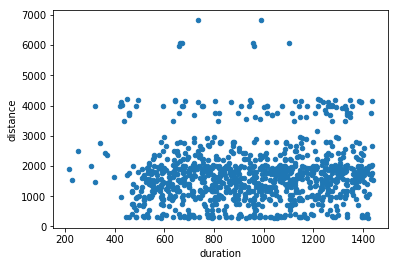

In [141]:
data.plot.scatter(x='distance', y='duration');